In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
!pip install yfinance

  Using cached yfinance-0.2.41-py2.py3-none-any.whl.metadata (11 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached peewee-3.17.6.tar.gz (3.0 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 1.6 MB/s eta 0:00:0000:01
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=293631 sha256=d0aa319d0a20e4100c7c827f1f9be87d33f4f8afa56b401cc376e9180a911335
  Stored in directory: /root/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee


In [7]:
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import yfinance as yf

In [8]:
ticker = 'RELIANCE.NS'
df = yf.download(ticker, start = '2010-01-01', end = '2024-08-01')

[*********************100%%**********************]  1 of 1 completed


In [9]:
df.shape

(3596, 6)

In [10]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,498.814209,498.814209,467.155457,491.682404,440.421967,38323043
2010-01-05,525.695618,525.695618,487.065033,489.488007,438.456299,10696412
2010-01-06,493.693939,500.368591,489.465149,497.397003,445.540771,11845880
2010-01-07,497.397003,509.740479,492.825348,505.648834,452.932312,13098960
2010-01-08,506.540314,509.191895,501.054321,504.323059,451.744781,7555074


In [11]:
# We only need Close column for prediction
df = df[['Close']].copy()

In [12]:
df.head()

,Close
Date,
2010-01-04,491.682404
2010-01-05,489.488007
2010-01-06,497.397003
2010-01-07,505.648834
2010-01-08,504.323059


In [13]:
df.describe()

,Close
count,3596.000000
mean,1081.890854
std,818.260509
min,309.090179
25%,427.233383
50%,607.025482
75%,1850.002899
max,3201.800049


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3596 entries, 2010-01-04 to 2024-07-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3596 non-null   float64
dtypes: float64(1)
memory usage: 56.2 KB


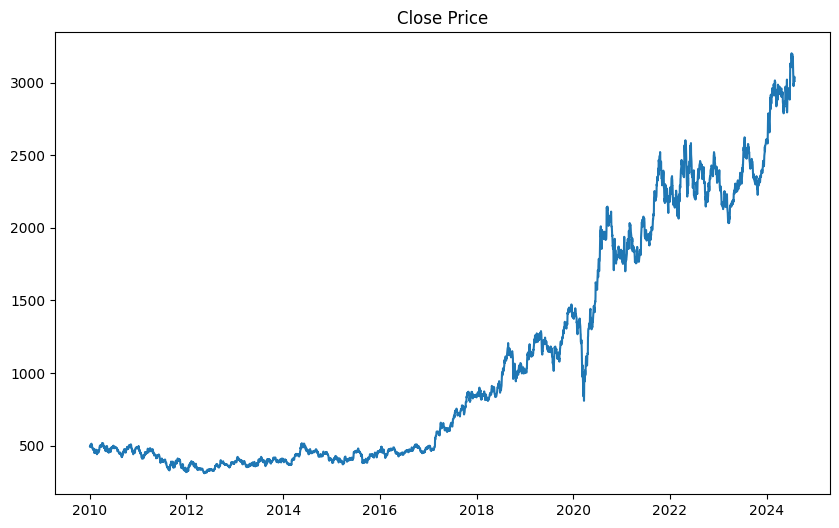

In [66]:

plt.figure(figsize=(10, 6))
plt.plot(df['Close'])
plt.title('Close Price')
plt.show()


### ARIMA

- p: Number of past observations to use.
- q: Number of past errors to use.
- d: Number of times differencing is applied to make the time series stationary.

### Check Stationarity using ADF
- Ho: Time series is non-stationary
- H1: Time series is staitonary

- p-value test: If p-value is less than the significance level (0.05) then we can reject the null hypothesis and infer the time series is stationary.
- p-value < 0.05 = stationary
- p-value > 0.05 = non - stationary; requires differencing

In [28]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [67]:
# decomposition = sm.tsa.seasonal_decompose(df.Close, model='additive')
# fig = decomposition.plot()
# plt.show()

In [16]:
#adf test

result = adfuller(df.Close.dropna()) 
print('ADF Statistic: ', result[0])
print('p-value: ', result[1])

ADF Statistic:  0.8692492308712378
p-value:  0.9926756076038599


p-value > 0.05. That means series is non- stationary. Next step is to make the series stationary by differencing.


## Differencing to make the series stationary

### 1. Manual differencing

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

ACF plots tell how many terms are required to remove any autocorrelation from the series

In [18]:
import matplotlib.pyplot as plt

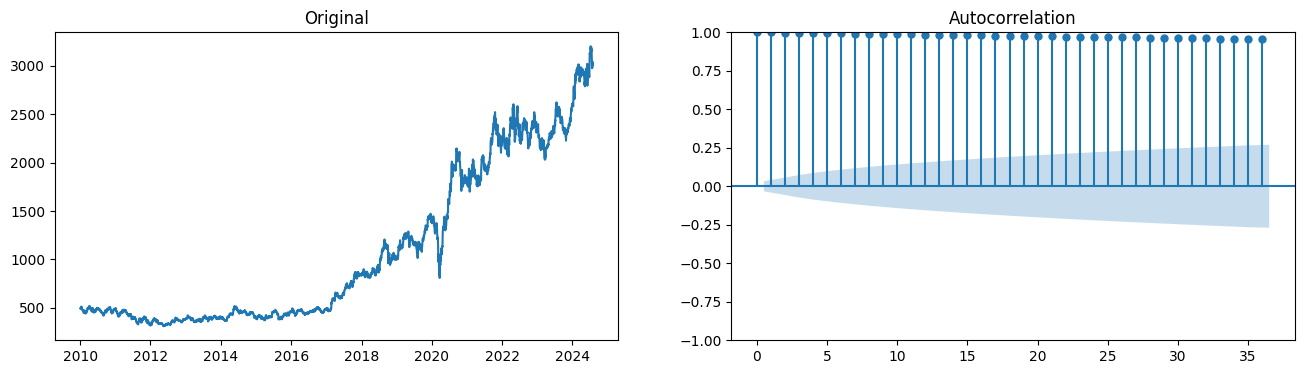

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(df.Close)
ax1.set_title("Original")
# add ; at the end of the plot function so that the plot is not duplicated
plot_acf(df.Close, ax=ax2);

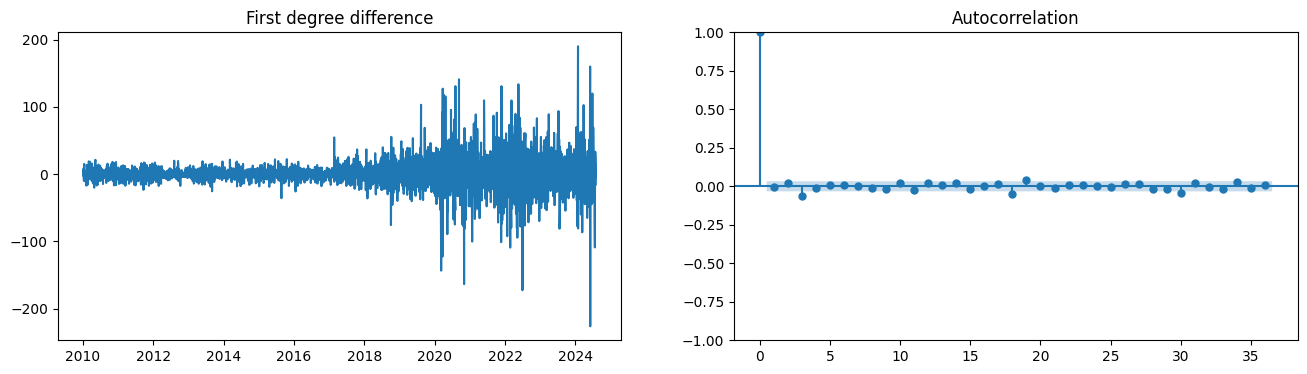

In [20]:
#First degree difference
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("First degree difference")
plot_acf (diff, ax=ax2);

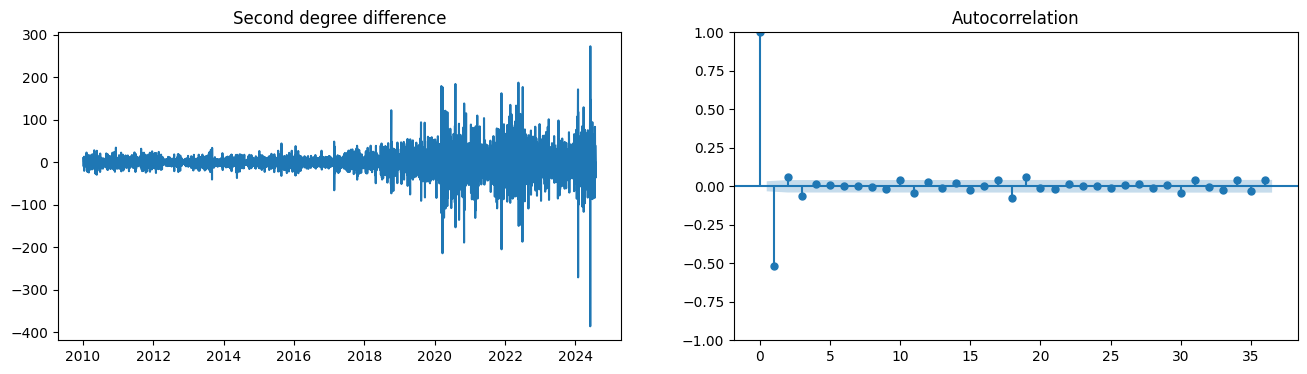

In [21]:
#Second degree difference
diff = df.Close.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Second degree difference")
plot_acf (diff, ax=ax2);

- The lag 1 is going far negative indicating the series might have been over-differenced.
- Choosing order of differencing = 1

### 2. pmdarima package for differencing

In [22]:
#!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.1 MB/s eta 0:00:0000:010:01


In [23]:
from pmdarima.arima.utils import ndiffs

In [24]:
ndiffs(df.Close, test = 'adf')

1

In [68]:
df['Close_diff'] = df['Close'].diff().dropna()

So, the ideal orderof differencing this series is 1, to make the series stationary.
We got d = 1.
let's move to find p and q.

### р
##### It is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors. We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot. The partial autocorrelation represents the correlation between the series and its lags.

In [25]:
from statsmodels.graphics.tsaplots import plot_pacf

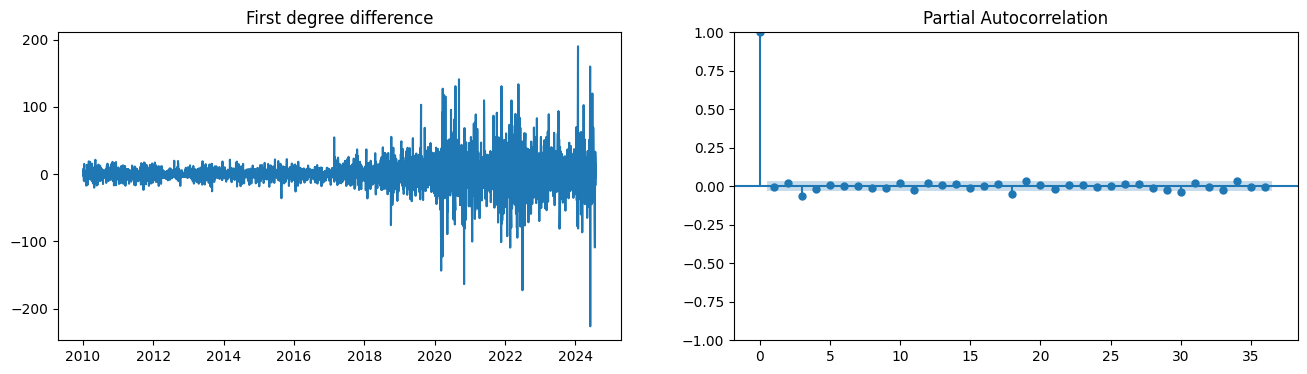

In [26]:
diff = df.Close.diff().dropna ()
fig, (axl, ax2) = plt.subplots(1, 2, figsize=(16, 4))
axl.plot(diff)
axl.set_title("First degree difference")
ax2.set_ylim(0, 1)
plot_pacf (diff, ax=ax2);

p : lag 3 and lag 18 are above significance line

### q
##### q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.
We can look at the ACF plot for the number of MA terms.


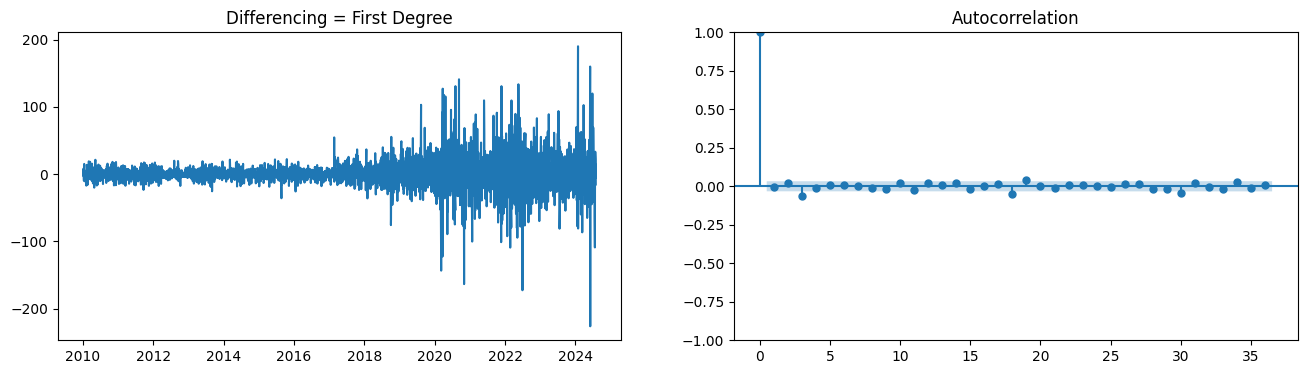

In [27]:
diff = df.Close.diff().dropna ()
fig, (axl, ax2) = plt.subplots(1, 2, figsize=(16, 4))
axl.plot(diff)
axl.set_title("Differencing = First Degree")
ax2.set_ylim (0, 1)
plot_acf (diff, ax=ax2);

q: lag 3 and lag 18

# Fitting ARIMA Model

In [46]:
from statsmodels.tsa.arima.model import ARIMA

In [69]:
#train test splt
train_size = int(len(df) * 0.8)
train, test = df['Close_diff'][:train_size], df['Close_diff'][train_size:]


In [48]:
from itertools import product

In [49]:
p = [3, 18]
q = [3, 18]
d = 1

params = product(p,q)

def evaluate_model(p,q):
    try:
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        mse = mean_squared_error(test, forecast)
        return (p, d, q, mse)
    except Exception as e:
        print(f'Error with p={p}, d={d}, q={q}: {e}')
        return (p, d, q, np.inf)

In [50]:
results = [evaluate_model(p, q) for p, q in params]

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/o

In [51]:
best_params = min(results, key=lambda x: x[3])
print(f'Best Parameters: p={best_params[0]}, d={best_params[1]}, q={best_params[2]} with MSE={best_params[3]}')

Best Parameters: p=18, d=1, q=18 with MSE=179497.29091124426


In [63]:
#train arima with the parameters(3,1,3)

model_3 = ARIMA(train, order = (3, 1, 3))
result_3  = model_3.fit()
forecast_3 = model_fit.forecast(steps=len(test))
mse_3 = mean_squared_error(test, forecast_3)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/o

NameError: name 'model_fit' is not defined

In [64]:
print(result_3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2876
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -12150.425
Date:                Sat, 10 Aug 2024   AIC                          24314.850
Time:                        10:47:21   BIC                          24356.597
Sample:                             0   HQIC                         24329.899
                               - 2876                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0213      0.216      4.721      0.000       0.597       1.445
ar.L2         -1.1243      0.036    -30.811      0.000      -1.196      -1.053
ar.L3          0.8380      0.211      3.963      0.0

In [61]:
#train arima with the best parameters

model_18 = ARIMA(df.Close, order = (18, 1, 18))
result_18  = model_18.fit()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/o

In [65]:
print(result_18.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3596
Model:               ARIMA(18, 1, 18)   Log Likelihood              -16177.390
Date:                Sat, 10 Aug 2024   AIC                          32428.779
Time:                        10:56:48   BIC                          32657.709
Sample:                             0   HQIC                         32510.371
                               - 3596                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1365      1.134      0.120      0.904      -2.085       2.358
ar.L2          0.2838      0.869      0.327      0.744      -1.420       1.987
ar.L3         -0.1982      0.276     -0.719      0.4

# AutoArima

In [70]:
from pmdarima import auto_arima

In [75]:
# #train 

# model = auto_arima(train, seasonal = False, stepwise = True, trace = True)
# print('Best paraneters: ', model.order)

model = auto_arima(train.dropna(), seasonal=False, stepwise=True, trace=True)
print(f'Best Parameters: {model.order}')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26257.965, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25423.762, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26255.966, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=25136.713, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=25009.914, Time=0.31 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=24829.370, Time=0.78 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=24772.058, Time=0.90 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=7.93 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=8.06 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=24770.063, Time=0.48 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=24827.373, Time=0.42 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=3.87 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Ti

# Forecasting and Evaluation


In [77]:
forecast_diff, conf_int = model.predict(n_periods=len(test), return_conf_int=True)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [79]:
# reverse differencing to get the forecast in the oriignal scale
forecast = np.cumsum(forecast_diff) + df['Close'].iloc[train_size]

MSE: 109272074.91965711


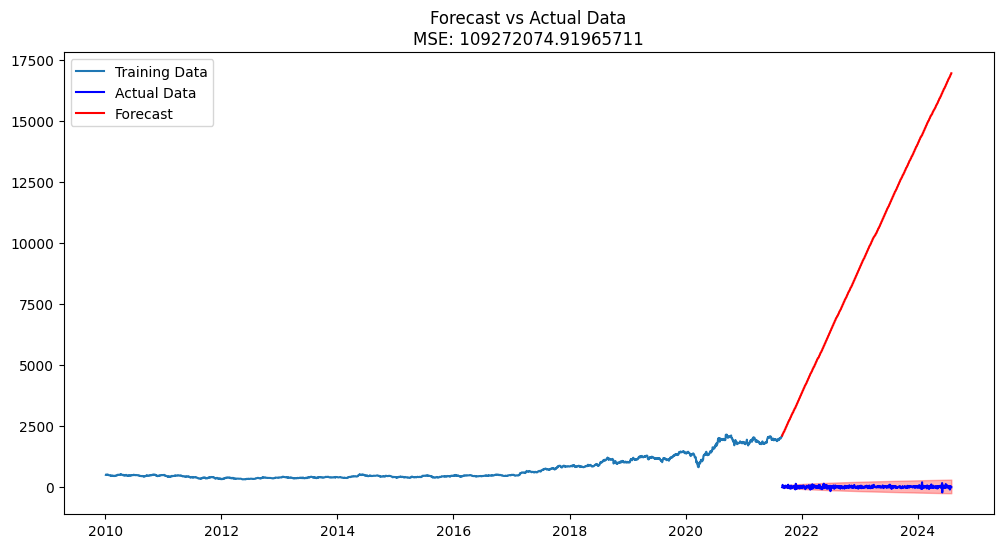

In [80]:
#evaluate and plot 

# Calculate MSE
mse = mean_squared_error(test, forecast)
print(f'MSE: {mse}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df.index[:train_size], df['Close'][:train_size], label='Training Data')
plt.plot(df.index[train_size:], test, label='Actual Data', color='blue')
plt.plot(df.index[train_size:], forecast, label='Forecast', color='red')
plt.fill_between(df.index[train_size:], 
                 conf_int[:, 0], 
                 conf_int[:, 1], 
                 color='red', alpha=0.3)
plt.legend()
plt.title(f'Forecast vs Actual Data\nMSE: {mse}')
plt.show()
